# Imports

In [1]:
%load_ext autoreload
%autoreload 2

# og python libs
import re
import os
import pprint
import itertools
from typing import Tuple, List, Dict, Pattern, Any


# classic DS libs
import pandas as pd
import numpy as np

# viz libs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from ipywidgets import interact, fixed, interact_manual

# scipy
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths, find_peaks_cwt
from scipy.constants import k as k_B
from scipy.constants import c, pi, N_A, h, hbar, m_e, m_p

# lmfit things
from lmfit.models import LinearModel, GaussianModel, VoigtModel, SplineModel, ExponentialModel, ExpressionModel, Model, ConstantModel
from lmfit import Parameter, Parameters
from lmfit import minimize, minimizer

# ML
from sklearn.linear_model import LinearRegression

# GenAI
from google import genai
from google.genai import types

# natural data databases
import hapi
DB_PATH = 'hapi_data'
hapi.db_begin(DB_PATH)

# API setups
G_MODEL_ID = "gemini-2.5-flash-preview-05-20"
G_API_KEY = os.environ.get("GEMINI_API_KEY")
G_CLIENT = genai.Client(api_key=G_API_KEY)

response = G_CLIENT.models.generate_content(
    model=G_MODEL_ID,
    contents="test",
)

print(response.text)

pp = pprint.PrettyPrinter(depth=4)

HAPI version: 1.2.2.3
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

In [2]:
# custom
import sys
sys.path.append('../../../../../../')
from my_utils import defs as cp
from my_utils.classes import CEPAS_measurement, CEPAS_benchmark, CEPAS_noise_info, CEPAS_SNR_bench
cp.hello_test()

Hello!


# Benchmark

In [3]:
pressure_list = [900]
freq_list_2 = [20, 170, 300]

benchmark_path_2 = "./"
benchmark_noise_2 = "./noise-tests/"

patterns = cp.create_regex_strings(pressure_list, freq_list_2)

test_bench_files = cp.dir_match_dict(benchmark_path_2, patterns) 
# pp.pprint(patterns)
# pp.pprint(test_bench_files)

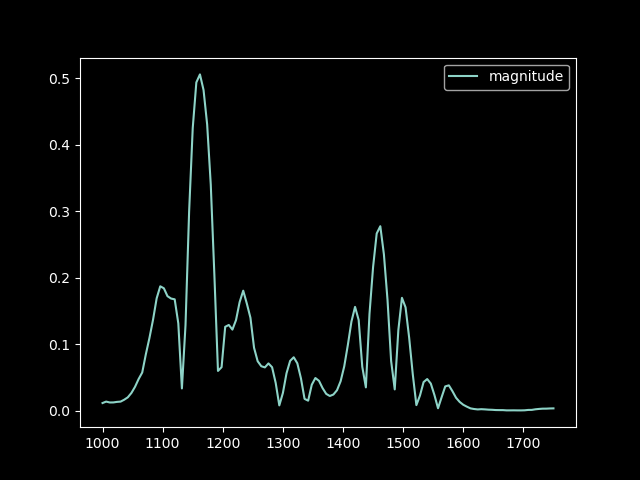

,time,offset1,P1,H3,H2,P_las,T_las,RH,Pressure,time_subtracted,H2_pnorm,H3_pnorm,wavenumbers,magnitude_pnorm
1,8025.367,1000.0,0.0,0.000028,-0.000441,0.034761,403.5192,32.34863,897.0,0.000,-0.011831,0.000761,6985.643439,0.011855
2,8027.175,1006.0,0.0,0.000088,-0.000521,0.034761,403.5192,32.34863,897.0,1.808,-0.013981,0.002371,6985.617254,0.014180
3,8028.982,1012.0,0.0,0.000077,-0.000512,0.034761,403.5192,32.34863,897.0,3.615,-0.013753,0.002080,6985.591070,0.013910
4,8030.686,1018.0,0.0,0.000106,-0.000480,0.034743,403.5192,32.34863,897.0,5.319,-0.012898,0.002836,6985.564885,0.013206
5,8032.490,1024.0,0.0,0.000171,-0.000503,0.034743,393.6961,32.34863,897.0,7.123,-0.013504,0.004582,6985.538700,0.014260


In [4]:


u1 = [1158.1, 1452.7]
u2 = [6984.9534710, 6983.6678]

# REMINDER frequencies: [20, 30, 40, 80, 90, 130, 170, 220, 300]
p = 900
f = 170
bench_test_2 = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
# bench_test.self_test()
bench_test_2.add_wav(u1, u2)
bench_test_2.add_magnitude()
test_avg = bench_test_2.get_avg()
target_peak = (1400, 1550)
bench_peaks = find_peaks_cwt(test_avg['H2_pnorm'], 10.0)
# print(bench_peaks)
# print(test_300_20)
%matplotlib widget

plt.close()
plt.figure()
# 1st test
# plt.plot(bench_test_2.spectra.spectra_list[0]['offset1'], bench_test_2.spectra.spectra_list[0]['H2_pnorm'])
# plt.plot(bench_test_2.spectra.spectra_list[1]['offset1'], bench_test_2.spectra.spectra_list[1]['H2_pnorm'])
# plt.plot(bench_test_2.spectra.spectra_list[2]['offset1'], bench_test_2.spectra.spectra_list[2]['H2_pnorm'])
# plt.plot(test_avg['offset1'][bench_peaks], test_avg['H2_pnorm'][bench_peaks], 'rx')
# plt.plot(test_avg['offset1'], test_avg['H2_pnorm'], label='avg')

# test magnitude
plt.plot(test_avg['offset1'], test_avg["magnitude_pnorm"], label="magnitude")

plt.legend()
# plt.xlim(1625, 1750)
# plt.ylim(-0.008, -0.0015)
plt.show()
bench_test_2.spectra.spectra_list[0].head()

# Signal

Uncomment below to see all the peaks used for bench

52    0.687643
Name: magnitude_pnorm, dtype: float64


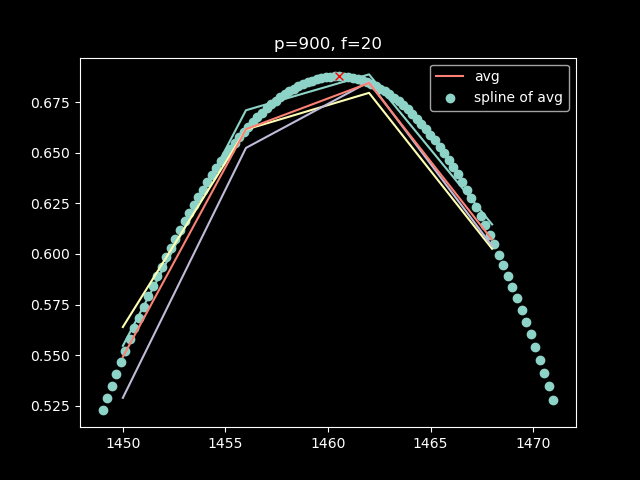

52    0.279393
Name: magnitude_pnorm, dtype: float64


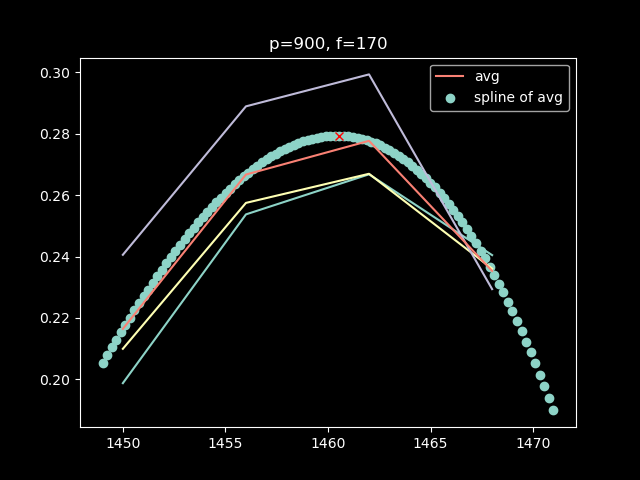

55    0.710194
Name: magnitude_pnorm, dtype: float64


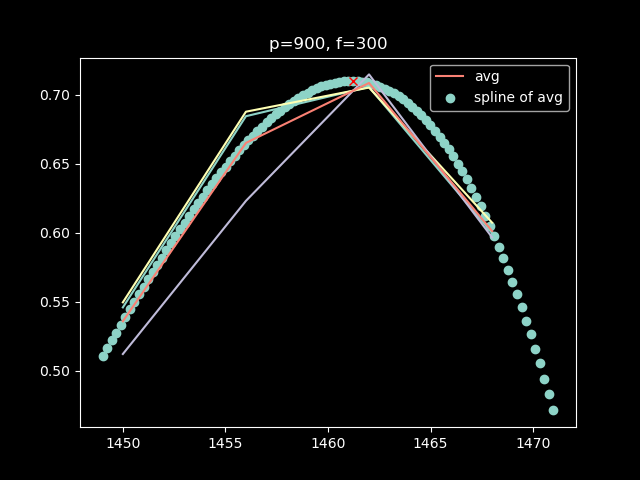

In [5]:
plt.close()
ps = [900]
fs = [20, 170, 300]
for p, f in itertools.product(ps, fs):
    bench_test = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
    bench_test.add_magnitude()
    peak_start = 1449
    peak_end = 1471
    peak = bench_test.get_window(peak_start, peak_end)
    peak_spline = bench_test.get_spline_of_window(n_spectrum=-1,
                                                  n_knots=4,
                                                  colx="offset1",
                                                  coly="magnitude_pnorm",
                                                  start=peak_start,
                                                  end=peak_end)
    # print(peak_spline[1])
    print(peak_spline[-1])
    plt.figure()
    plt.plot(peak[0]['offset1'], peak[0]['magnitude_pnorm'])
    plt.plot(peak[1]['offset1'], peak[1]["magnitude_pnorm"])
    plt.plot(peak[2]['offset1'], peak[2]["magnitude_pnorm"])
    plt.plot(peak[3]['offset1'], peak[3]['magnitude_pnorm'], label='avg')
    plt.scatter(peak_spline[2]['offset1'], peak_spline[2]['magnitude_pnorm'], label='spline of avg')
    plt.plot(peak_spline[-2]['offset1'], peak_spline[-2]['magnitude_pnorm'], 'rx')
    plt.legend()
    plt.title(f"p={p}, f={f}")
    plt.show()

# Noise

4.702e-05


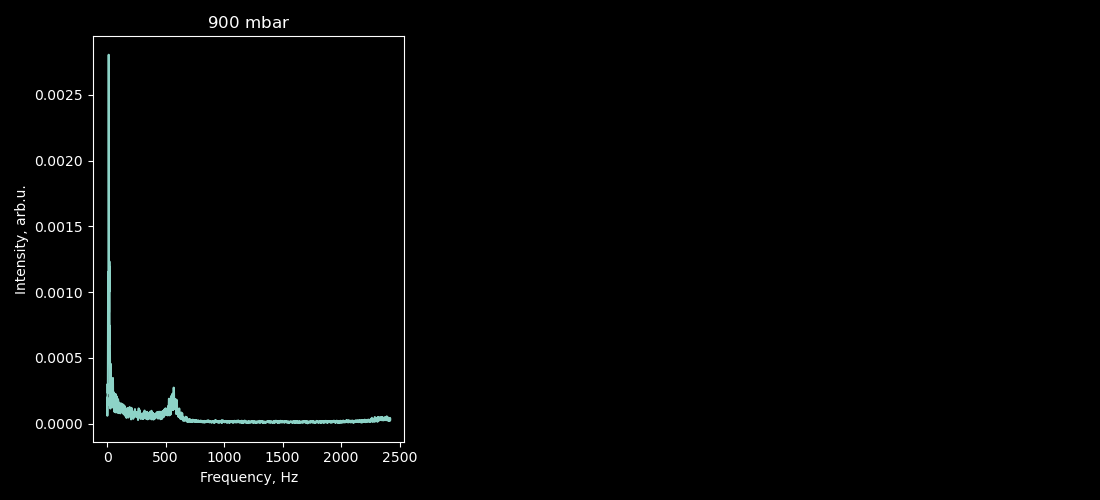

In [6]:
# bench_noise_300_2 = CEPAS_noise_info(benchmark_noise_2, 300)
# bench_noise_600_2 = CEPAS_noise_info(benchmark_noise_2, 600)
bench_noise_900_2 = CEPAS_noise_info(benchmark_noise_2, 900)

backgrounds = { # 300: bench_noise_300_2,
            #    600: bench_noise_600_2,
               900: bench_noise_900_2}


print(f"{np.format_float_scientific(bench_noise_900_2.get_noise_at(f), precision=3)}")
plt.close()
plt.figure(figsize=(11, 5))
# plt.subplot(131)
# plt.title("$300\\ \\text{mbar}$")
# plt.xlabel('Frequency, Hz')
# plt.ylabel('Intensity, arb.u.')
# plt.plot(bench_noise_300_2.spectrum['freq'], bench_noise_300_2.spectrum['intensity'])
# plt.subplot(132)
# plt.title("$600\\ \\text{mbar}$")
# plt.xlabel('Frequency, Hz')
# plt.ylabel('Intensity, arb.u.')
# plt.plot(bench_noise_600_2.spectrum['freq'], bench_noise_600_2.spectrum['intensity'])
plt.subplot(131)
plt.title("$900\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_900_2.spectrum['freq'], bench_noise_900_2.spectrum['intensity'])
plt.tight_layout()
plt.show()

In [7]:
noise_start_2 = 1625
noise_end_2 = 1749
peak_start_2 = 1449
peak_end_2 = 1471

bench_final_2 = CEPAS_SNR_bench(test_bench_files,
                                bench_path=benchmark_path_2,
                                noise_path=benchmark_noise_2,
                                file_sig="single")

get_all = bench_final_2.get_mag_snrs(peak_start_2,
                                     peak_end_2,
                                     n_knots=4)

snrs = get_all[0]
noises = get_all[1]  # single, background
signals = get_all[2]

signals.index
bench_final_2

'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=900                         and f=20 signal is 
---->52    0.687643
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 8.908144707774926e-05
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=900                         and f=170 signal is 
---->52    0.279393
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 2.4435477195289657e-05
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=900                         and f=300 signal is 
---->55    0.710194
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 4.401904312182723e-05


In [8]:
noises

,900
20,"[8.908144707774926e-05, 0.0009033472592592592]"
170,"[2.4435477195289657e-05, 9.145899629629631e-05]"
300,"[4.401904312182723e-05, 4.702495555555557e-05]"


/tmp/ipykernel_69940/3235812139.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'signal': [float(signals[900][f][0]) for f in snrs.index],
/tmp/ipykernel_69940/3235812139.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


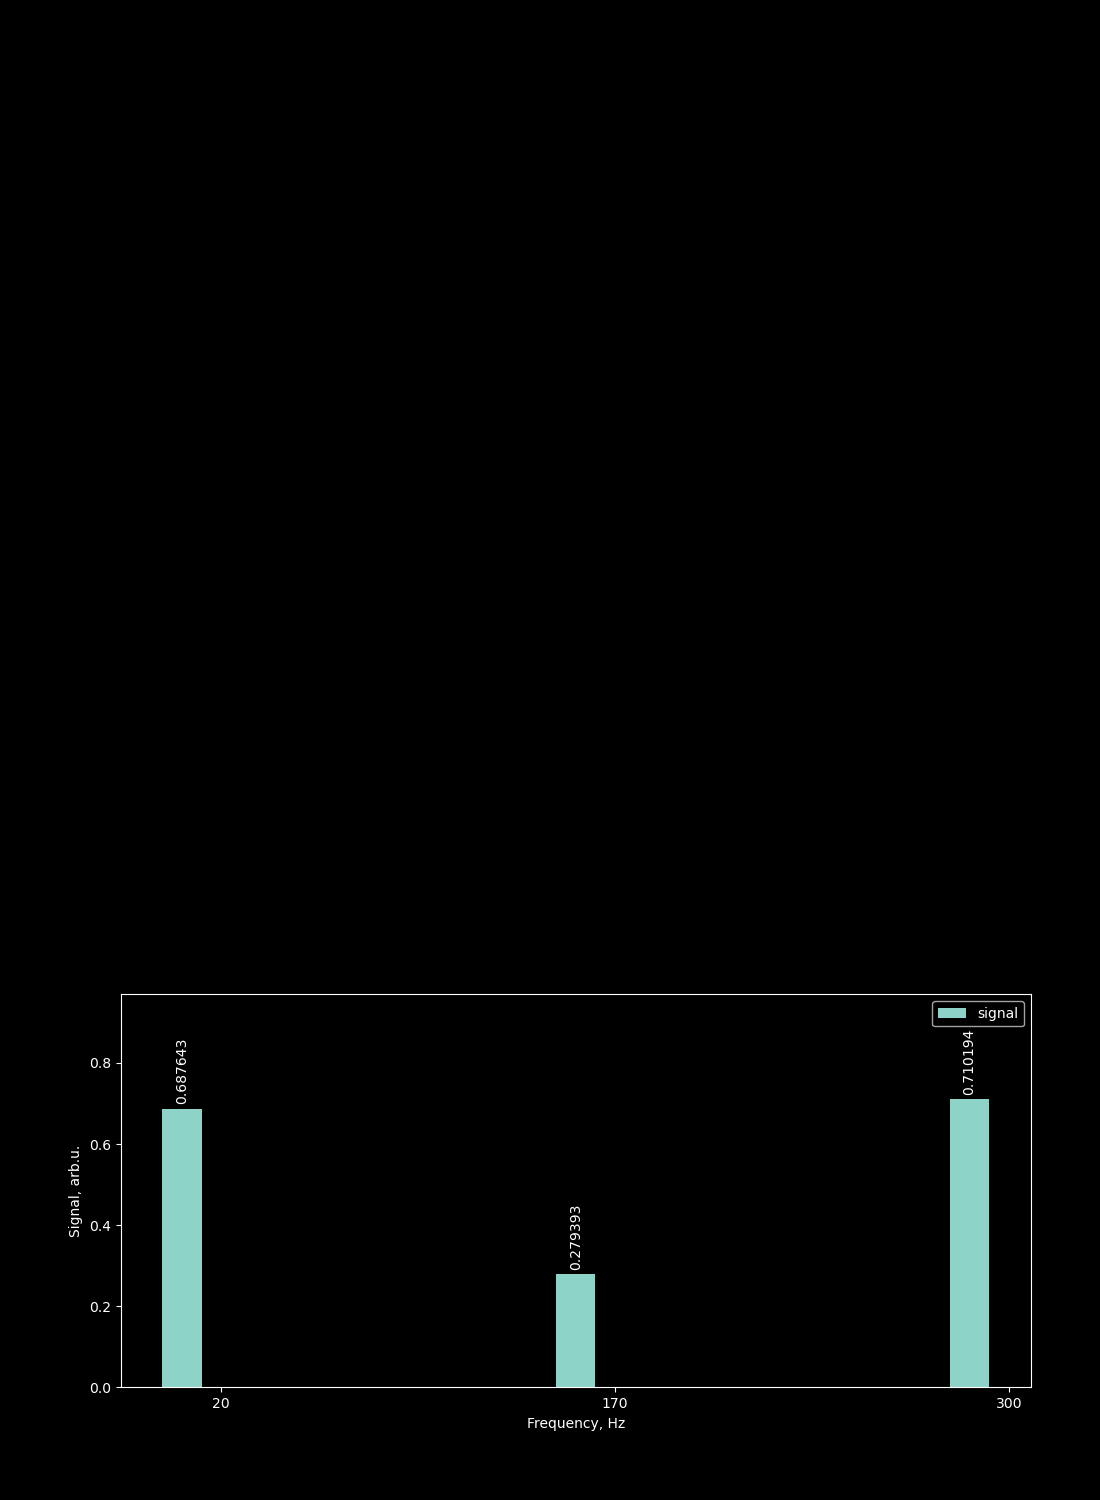

In [12]:
# signals300 = {
#     'signal': [float(signals[300][f][0]) for f in signals.index],
#     # 'background': [float(signals[300][f][1]) for f in signals.index]
# }

# signals600 = {
#     'signal': [float(signals[600][f][0]) for f in signals.index],
#     # 'background': [float(signals[600][f][1]) for f in signals.index]
# }

signals900 = {
    'signal': [float(signals[900][f][0]) for f in snrs.index],
    # 'background': [float(signals[900][f][1]) for f in snrs.index]
}

frequencies = snrs.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 15), constrained_layout=True)

# ax1 = plt.subplot(311)
# for k, v in signals300.items():
#     offset = (width+spacing) * multiplier
#     rects = ax1.bar(x+offset, v, width, label=k)
#     ax1.bar_label(rects, rotation=90, padding=3)
#     multiplier += 1
# ax1.set_xticks(x+width, np.round(list(frequencies), 2))
# ax1.set_xlabel('Frequency, Hz')
# ax1.set_ylabel('Signal, arb.u.')
# old_top = ax1.get_ylim()[1]
# new_top = old_top*top_align
# ax1.set_ylim(top=new_top)
# ax1.legend()
multiplier = 0

# ax2 = plt.subplot(312)
# for k, v in signals600.items():
#     offset = (width+spacing) * multiplier
#     rects = ax2.bar(x+offset, v, width, label=k)
#     ax2.bar_label(rects, rotation=90, padding=3)
#     multiplier += 1
# ax2.set_xticks(x+width, np.round(list(frequencies), 2))
# ax2.set_xlabel('Frequency, Hz')
# ax2.set_ylabel('Signal, arb.u.')
# old_top = ax2.get_ylim()[1]
# new_top = old_top*top_align
# ax2.set_ylim(top=new_top)
# ax2.legend()
multiplier = 0

ax3 = plt.subplot(313)
for k, v in signals900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('Signal, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

/tmp/ipykernel_69940/3181750091.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


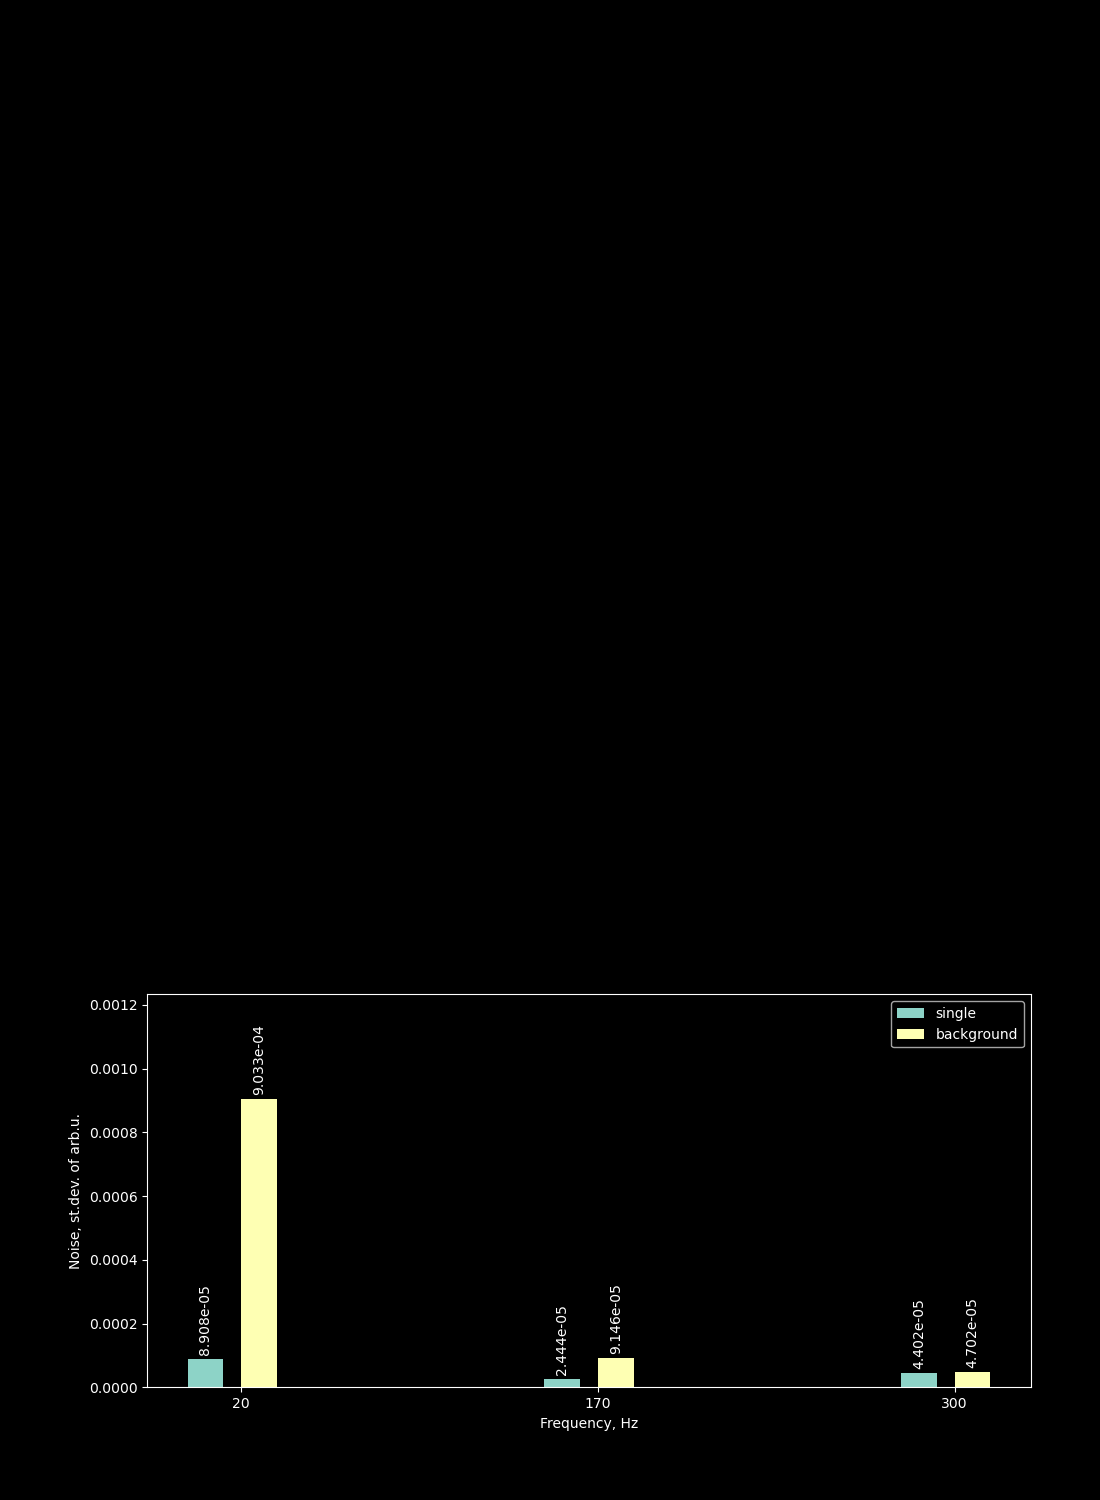

In [10]:
# noises300 = {
#     'single': [noises[300][f][0] for f in noises.index],
#     'background': [noises[300][f][1] for f in noises.index]
# }

# noises600 = {
#     'single': [noises[600][f][0] for f in noises.index],
#     'background': [noises[600][f][1] for f in noises.index]
# }

noises900 = {
    'single': [noises[900][f][0] for f in noises.index],
    'background': [noises[900][f][1] for f in noises.index]
}

frequencies = noises.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 15), constrained_layout=True)

# ax1 = plt.subplot(311)
# for k, v in noises300.items():
#     offset = (width+spacing) * multiplier
#     rects = ax1.bar(x+offset, v, width, label=k)
#     ax1.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
#     multiplier += 1
# ax1.set_xticks(x+width, np.round(list(frequencies), 2))
# ax1.set_xlabel('Frequency, Hz')
# ax1.set_ylabel('Noise, st.dev. of arb.u.')
# old_top = ax1.get_ylim()[1]
# new_top = old_top*top_align
# ax1.set_ylim(top=new_top)
# ax1.legend()
# multiplier = 0

# ax2 = plt.subplot(312)
# for k, v in noises600.items():
#     offset = (width+spacing) * multiplier
#     rects = ax2.bar(x+offset, v, width, label=k)
#     ax2.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
#     multiplier += 1
# ax2.set_xticks(x+width, np.round(list(frequencies), 2))
# ax2.set_xlabel('Frequency, Hz')
# ax2.set_ylabel('Noise, st.dev. of arb.u.')
# old_top = ax2.get_ylim()[1]
# new_top = old_top*top_align
# ax2.set_ylim(top=new_top)
# ax2.legend()
# multiplier = 0

ax3 = plt.subplot(313)
for k, v in noises900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('Noise, st.dev. of arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

/tmp/ipykernel_69940/231427122.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


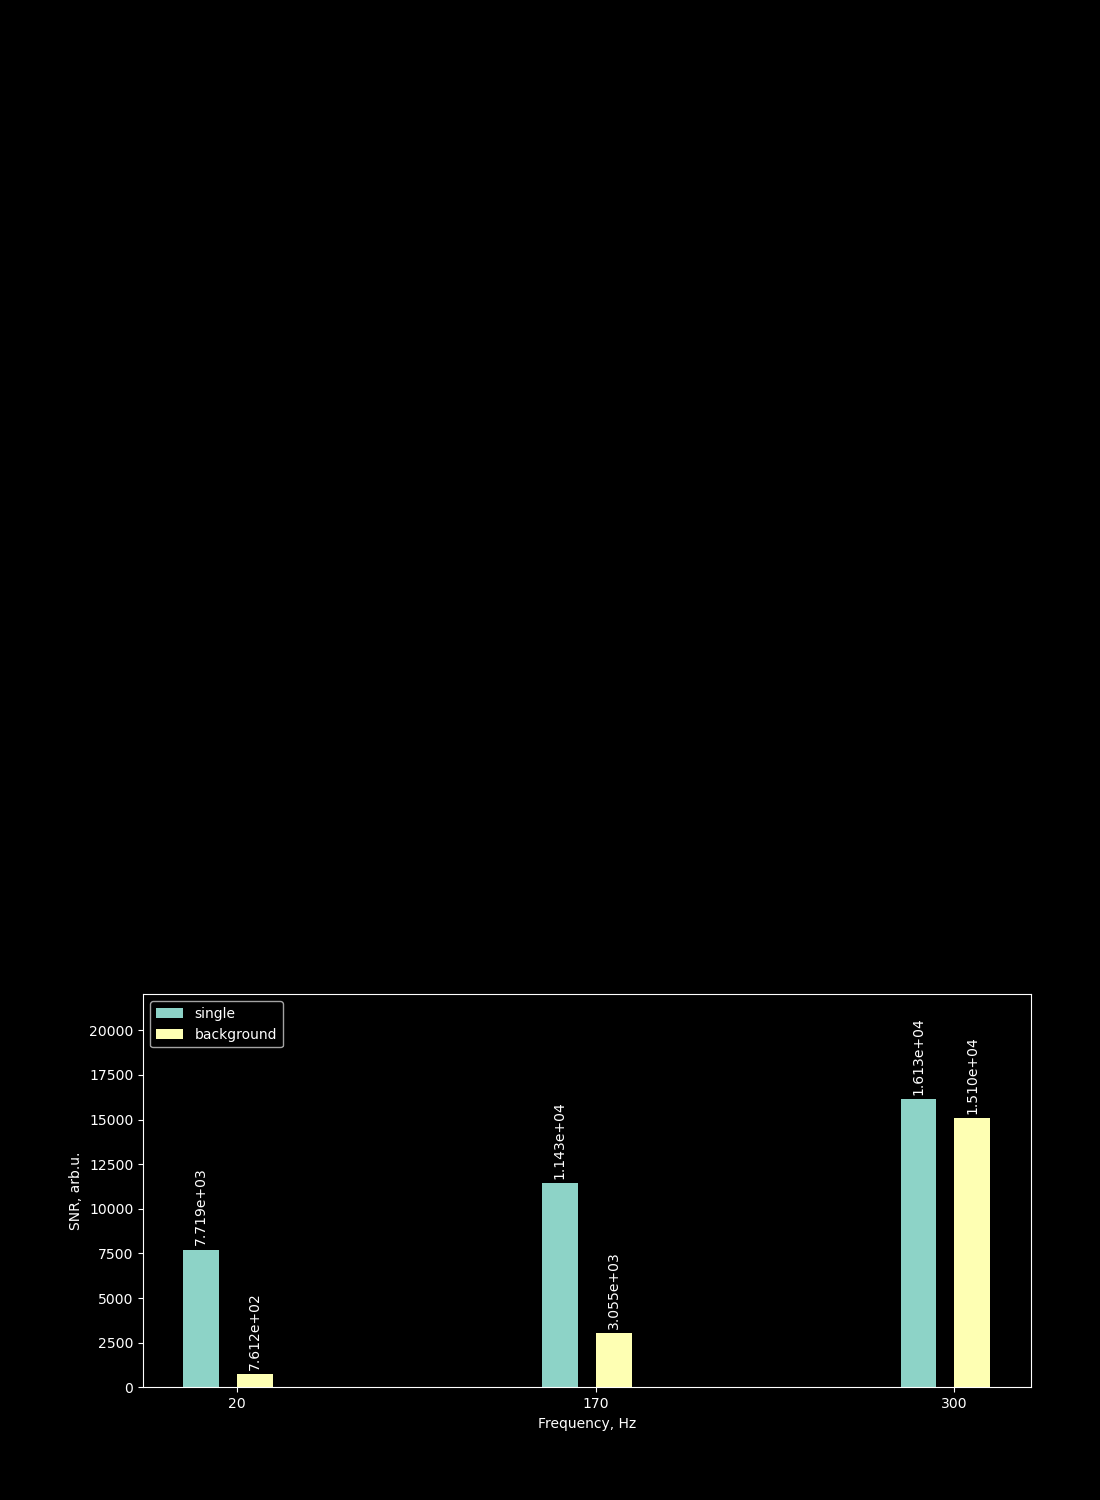

In [13]:
# snrs300 = {
#     'single': [snrs[300][f][0] for f in snrs.index],
#     'background': [snrs[300][f][1] for f in snrs.index]
# }

# snrs600 = {
#     'single': [snrs[600][f][0] for f in snrs.index],
#     'background': [snrs[600][f][1] for f in snrs.index]
# }

snrs900 = {
    'single': [snrs[900][f][0] for f in snrs.index],
    'background': [snrs[900][f][1] for f in snrs.index]
}

frequencies = snrs.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 15), constrained_layout=True)

# ax1 = plt.subplot(311)
# for k, v in snrs300.items():
#     offset = (width+spacing) * multiplier
#     rects = ax1.bar(x+offset, v, width, label=k)
#     ax1.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
#     multiplier += 1
# ax1.set_xticks(x+width, np.round(list(frequencies), 2))
# ax1.set_xlabel('Frequency, Hz')
# ax1.set_ylabel('SNR, arb.u.')
# old_top = ax1.get_ylim()[1]
# new_top = old_top*top_align
# ax1.set_ylim(top=new_top)
# ax1.legend()
# multiplier = 0

# ax2 = plt.subplot(312)
# for k, v in snrs600.items():
#     offset = (width+spacing) * multiplier
#     rects = ax2.bar(x+offset, v, width, label=k)
#     ax2.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
#     multiplier += 1
# ax2.set_xticks(x+width, np.round(list(frequencies), 2))
# ax2.set_xlabel('Frequency, Hz')
# ax2.set_ylabel('SNR, arb.u.')
# old_top = ax2.get_ylim()[1]
# new_top = old_top*top_align
# ax2.set_ylim(top=new_top)
# ax2.legend()
# multiplier = 0

ax3 = plt.subplot(313)
for k, v in snrs900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('SNR, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()